In [1]:
import numpy as np
import os
import sys
import astropy.units as u
import astropy.constants as constants
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.facecolor'] = 'w'

kl_path = '/Users/sweveret/repos/KLens'
sys.path.insert(0, kl_path)
from tfCube2 import GalaxyImage, TFCube

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
import utils

## Set Mutual Parameters

In [2]:
sampled_pars = {
    'g1': 0.05,
    'g2': -0.025,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

im_pars = {
    'flux': 1e5,
    'hlr':5,
}

pars = {
    'redshift': 0.3,
    'resolution': 5000,
    'pixel_scale': 1., # to simplify a few things
    'throughput': 1., # keep it simple
    'Nx': 30,
    'Ny': 30,
    'psf': {
        'type': 'Gaussian', # Matches what is in tfCube
        'fwhm': 3, # arcsec / pixels (same in this case)
    },
    'v_unit': u.Unit('km/s'),
    'r_unit': u.Unit('pix')
}

## Setup TFCube Parameters

In [3]:
tf_pars = {}

mutual_sampled_keys = ['g1', 'g2', 'sini', 'theta_int', 'vcirc']
for key in mutual_sampled_keys:
    tf_pars[key] = sampled_pars[key]
    
tf_pars['v_0'] = sampled_pars['v0']
tf_pars['vscale'] = sampled_pars['rscale']
tf_pars['r_0'] = 0.
    
mutual_pars_keys = ['redshift']
for key in mutual_pars_keys:
    tf_pars[key] = pars[key]
    
# a few oddities
tf_pars['Resolution'] = pars['resolution']
tf_pars['aspect'] = 0.1 # matches GalSim default

tf_pars['r_hl_image'] = im_pars['hlr']
tf_pars['r_hl_spec'] = im_pars['hlr']

tf_pars['slitWidth'] = 0.06

assert pars['Nx'] == pars['Ny']
tf_pars['ngrid'] = pars['Nx']
tf_pars['image_size'] = pars['Nx']

tf_pars['norm'] = 0.0

tf_pars['expTime'] = 60.*30. #60.*30.

tf_pars['pixScale'] = pars['pixel_scale']
tf_pars['subGridPixScale'] = pars['pixel_scale']

tf_pars['offset_x'] = 0.
tf_pars['offset_y'] = 0.

tf_pars['nm_per_pixel'] = 0.1
tf_pars['throughput'] = pars['throughput']

tf_pars['psfFWHM'] = pars['psf']['fwhm']
tf_pars['psf_g1'] = 0.0
tf_pars['psf_g2'] = 0.0

tf_pars['area'] = 3.14 * (1000./2.)**2 

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
# We'll do just Halpha
linelist['species'] = ['Halpha']
linelist['lambda'] = [656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

tf_pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=tf_pars['sini'], q_z=tf_pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=tf_pars['g1'])
theta_obs = cal_theta_obs(g2=tf_pars['g2'], e_int=eint_thy, theta_int=tf_pars['theta_int'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

tf_pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

###### find flux normormalization ######

tf_pars['flux'] = find_flux_norm(tf_pars, R=1.5)
print("flux_norm", tf_pars['flux'])

avgFlux_per_pix = avgFlux_in_R_per_pix(tf_pars, flux=tf_pars['flux'], R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)

##############################
line_species='Halpha'

2.9999999999999994e-16 erg / (cm2 nm s)


/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/4096877164.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('lambda',np.float),
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/4096877164.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ('flux',np.float)])


### Make a TFCube

In [4]:
TF = TFCube(pars=tf_pars, line_species=line_species)
print(vars(TF).keys())

dict_keys(['Pars', 'GalIMAGE', 'line_species', 'c_kms', 'c_cgs', 'h_cgs', 'cosi', 'lambdaGrid_more', 'lambdaGrid', 'spaceGrid', 'X', 'Y', 'photonObsFactor', 'slit_weight', 'specInterp', 'skySpec1D', 'skyCube', 'skySpec', 'modelImg', 'modelCube'])


### Check TF imap

sum=2080.86; sig=0.0016


Text(0.5, 1.0, 'Residual')

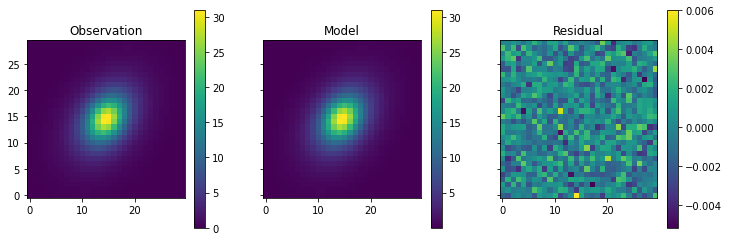

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,4))

plt.subplot(131)
obsImg, obs_var = TF.GalIMAGE.observation(signal_to_noise=100000.)
print(f'sum={np.sum(obsImg):.2f}; sig={np.sqrt(obs_var):.4f}')
plt.imshow(obsImg, origin='lower')
plt.colorbar()
plt.title('Observation')

plt.subplot(132)
plt.imshow(TF.modelImg, origin='lower')
plt.colorbar()
plt.title('Model')

plt.subplot(133)
plt.imshow(obsImg-TF.modelImg, origin='lower')
plt.colorbar()
plt.title('Residual')

### Look at TF datacube

In [6]:
tf_datacube = TF.observation3D()
print(tf_datacube.shape)


(30, 30, 41)


### Compare vmaps

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/327147764.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(TF.X, TF.Y, tf_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/327147764.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/327147764.py:38: MatplotlibDeprecationWarning: sh

Text(0.5, 0.98, 'Vmap comparison for g=(0.050,-0.025); sini=0.80; vcirc=200.0')

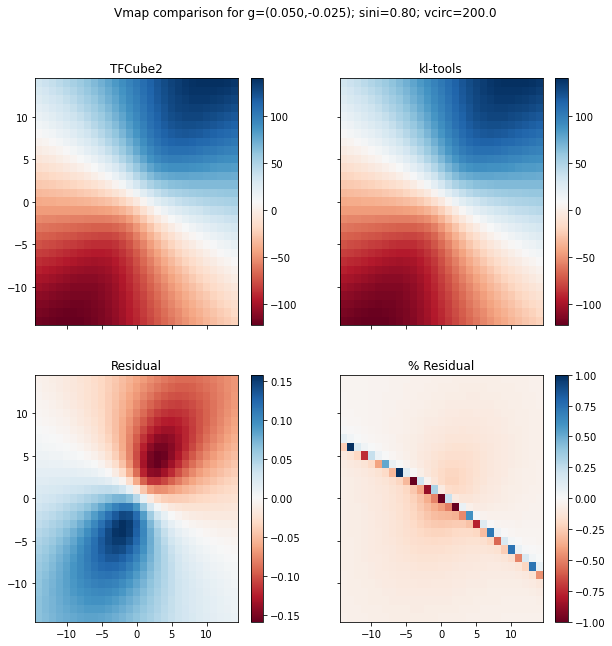

In [7]:
c_kms = constants.c.to('km / s').value
tf_vmap = c_kms*TF.getVmap(
                  tf_pars['vcirc'],
                  tf_pars['sini'],
                  tf_pars['g1'],
                  tf_pars['g2'],
                  tf_pars['vscale'],
                  tf_pars['v_0'],
                  tf_pars['r_0'],
                  tf_pars['theta_int']
                 )

unit_pars = {
    'v_unit': pars['v_unit'],
    'r_unit': pars['r_unit']
}
vmap_pars = {**sampled_pars, **unit_pars}
kl_Vmap = VelocityMap('default', vmap_pars)
X, Y = utils.build_map_grid(pars['Nx'], pars['Ny'])
kl_vmap = kl_Vmap('obs', X, Y)

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(TF.X, TF.Y, tf_vmap, cmap='RdBu')
plt.title('TFCube2')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
plt.title('kl-tools')
plt.colorbar()

plt.subplot(223)
assert (X == TF.X).all()
assert (Y == TF.Y).all()
resid = kl_vmap-tf_vmap
plt.pcolormesh(X, Y, resid, cmap='RdBu')
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
assert (X == TF.X).all()
assert (Y == TF.Y).all()
plt.pcolormesh(X, Y, 100.*resid/tf_vmap, cmap='RdBu',
               vmin=-1, vmax=1)
plt.title('% Residual')
plt.colorbar()

g1, g2 = sampled_pars['g1'], sampled_pars['g2']
sini = sampled_pars['sini']
vcirc = sampled_pars['vcirc']
plt.suptitle(f'Vmap comparison for g=({g1:.3f},{g2:.3f}); sini={sini:.2f}; vcirc={vcirc:.1f}')

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/3593742044.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(alt_TF.X, alt_TF.Y, alt_tf_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/3593742044.py:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, alt_kl_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/3593742044.py:57: MatplotlibDep

Text(0.5, 0.98, 'Vmap comparison for g=(-0.025,-0.025); sini=0.57; vcirc=278.4')

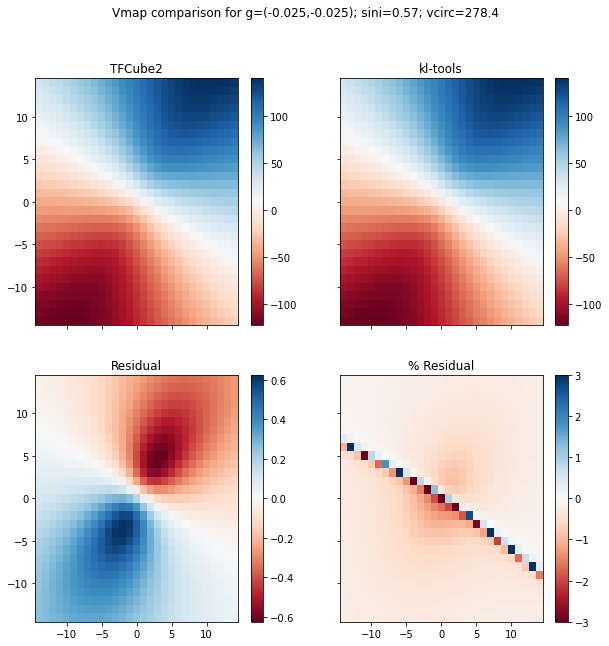

In [8]:
alt_pars = {
    'g1': -0.0255,
    'g2': 0.1082,
    'theta_int': 1.0437,
    'sini': 0.5724,
    'v0': 10.0144,
    'vcirc': 278.4138,
    'rscale': 4.2491,
    }

alt_tf_pars = tf_pars.copy()
for par in ['vcirc', 'g1', 'g2', 'sini', 'theta_int']:
    alt_tf_pars[par] = alt_pars[par]
alt_tf_pars['vscale'] = alt_pars['rscale']
alt_tf_pars['v_0'] = alt_pars['v0']
alt_tf_pars['r_0'] = 0.

alt_TF = TFCube(pars=alt_tf_pars, line_species=line_species)

c_kms = constants.c.to('km / s').value
alt_tf_vmap = c_kms*alt_TF.getVmap(
                  alt_tf_pars['vcirc'],
                  alt_tf_pars['sini'],
                  alt_tf_pars['g1'],
                  alt_tf_pars['g2'],
                  alt_tf_pars['vscale'],
                  alt_tf_pars['v_0'],
                  alt_tf_pars['r_0'],
                  alt_tf_pars['theta_int']
                 )

unit_pars = {
    'v_unit': pars['v_unit'],
    'r_unit': pars['r_unit']
}
alt_vmap_pars = {**alt_pars, **unit_pars}
alt_kl_Vmap = VelocityMap('default', alt_vmap_pars)
X, Y = utils.build_map_grid(pars['Nx'], pars['Ny'])
alt_kl_vmap = alt_kl_Vmap('obs', X, Y)

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(alt_TF.X, alt_TF.Y, alt_tf_vmap, cmap='RdBu')
plt.title('TFCube2')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(X, Y, alt_kl_vmap, cmap='RdBu')
plt.title('kl-tools')
plt.colorbar()

plt.subplot(223)
assert (X == alt_TF.X).all()
assert (Y == alt_TF.Y).all()
resid = alt_kl_vmap-alt_tf_vmap
plt.pcolormesh(X, Y, resid, cmap='RdBu')
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(X, Y, 100.*resid/alt_tf_vmap, cmap='RdBu',
               vmin=-3, vmax=3)
plt.title('% Residual')
plt.colorbar()

ag1, ag2 = alt_pars['g1'], sampled_pars['g2']
asini = alt_pars['sini']
avcirc = alt_pars['vcirc']
plt.suptitle(f'Vmap comparison for g=({ag1:.3f},{ag2:.3f}); sini={asini:.2f}; vcirc={avcirc:.1f}')

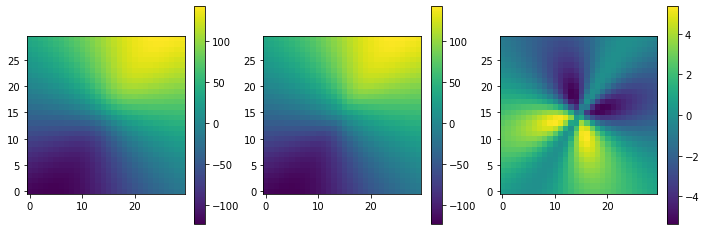

In [11]:
alt_tf_pars = tf_pars.copy()
for par in ['vcirc', 'g1', 'g2', 'sini', 'theta_int']:
    alt_tf_pars[par] = alt_pars[par]
alt_tf_pars['vscale'] = alt_pars['rscale']
alt_tf_pars['v_0'] = alt_pars['v0']
alt_tf_pars['r_0'] = 0.

alt_TF = TFCube(pars=alt_tf_pars, line_species=line_species)

c_kms = constants.c.to('km / s').value
alt_tf_vmap = c_kms*alt_TF.getVmap(
                  alt_tf_pars['vcirc'],
                  alt_tf_pars['sini'],
                  alt_tf_pars['g1'],
                  alt_tf_pars['g2'],
                  alt_tf_pars['vscale'],
                  alt_tf_pars['v_0'],
                  alt_tf_pars['r_0'],
                  alt_tf_pars['theta_int']
                 )

v1 = c_kms*TF.getVmap(
                  tf_pars['vcirc'],
                  tf_pars['sini'],
                  tf_pars['g1'],
                  tf_pars['g2'],
                  tf_pars['vscale'],
                  tf_pars['v_0'],
                  tf_pars['r_0'],
                  tf_pars['theta_int']
                 )
v2 = c_kms*alt_TF.getVmap(
                  tf_pars['vcirc'],
                  tf_pars['sini'],
                  tf_pars['g1'],
                  tf_pars['g2'],
                  tf_pars['vscale'],
                  tf_pars['v_0'],
                  tf_pars['r_0'],
                  tf_pars['theta_int']
                 )

plt.subplot(131)
plt.imshow(v1, origin='lower')
plt.colorbar()
plt.subplot(132)
plt.imshow(v2, origin='lower')
plt.colorbar()
plt.subplot(133)
plt.imshow(v2-v1, origin='lower')
plt.colorbar()

plt.gcf().set_size_inches(12, 4)

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, tf_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(alt_TF.X, alt_TF.Y, alt_tf_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:19: MatplotlibDeprecat

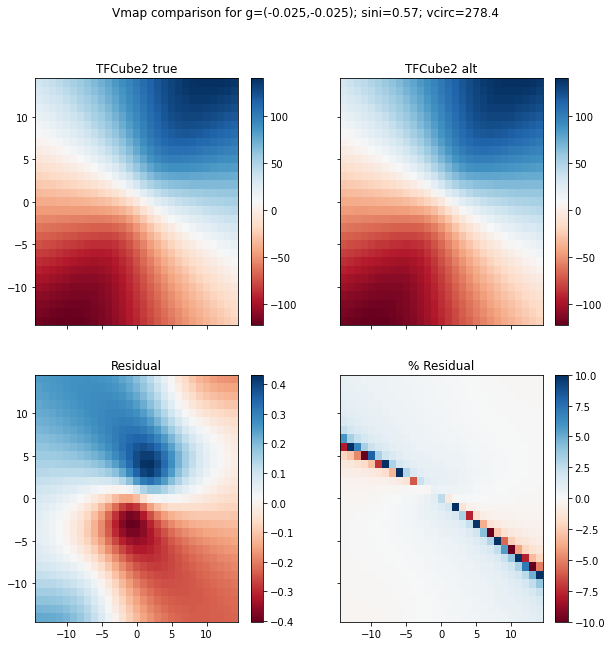

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, alt_kl_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_31373/1964952208.py:50: MatplotlibDeprecationWarning: s

Text(0.5, 0.98, 'Vmap comparison for g=(-0.025,-0.025); sini=0.57; vcirc=278.4')

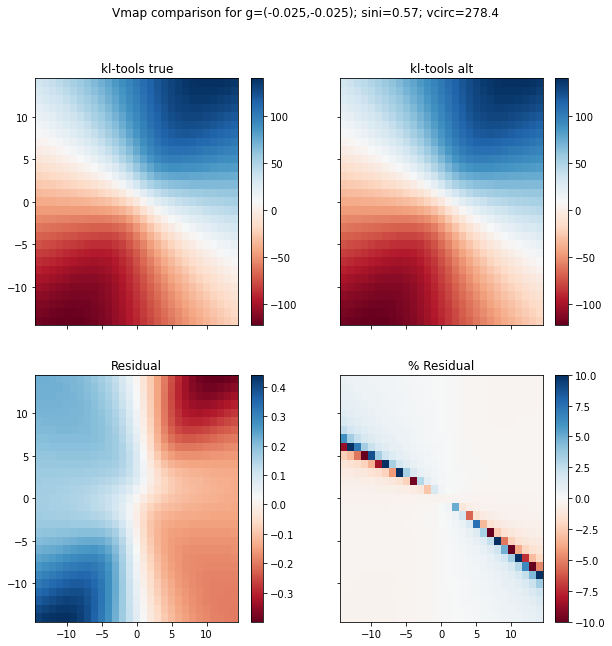

In [10]:
# now compare tfcube2 for both true and alt solutions

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(X, Y, tf_vmap, cmap='RdBu')
plt.title('TFCube2 true')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(alt_TF.X, alt_TF.Y, alt_tf_vmap, cmap='RdBu')
plt.title('TFCube2 alt')
plt.colorbar()

plt.subplot(223)
resid = alt_tf_vmap-tf_vmap
assert (X == TF.X).all()
assert (Y == TF.Y).all()
plt.pcolormesh(X, Y, resid, cmap='RdBu')
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(X, Y, 100.*resid/tf_vmap, cmap='RdBu',
               vmin=-10, vmax=10)
plt.title('% Residual')
plt.colorbar()
ag1, ag2 = alt_pars['g1'], sampled_pars['g2']
asini = alt_pars['sini']
avcirc = alt_pars['vcirc']
plt.suptitle(f'Vmap comparison for g=({ag1:.3f},{ag2:.3f}); sini={asini:.2f}; vcirc={avcirc:.1f}')
plt.show()

# now compare kl-tools for both true and alt solutions

plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))

plt.subplot(221)
plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
plt.title('kl-tools true')
plt.colorbar()

plt.subplot(222)
plt.pcolormesh(X, Y, alt_kl_vmap, cmap='RdBu')
plt.title('kl-tools alt')
plt.colorbar()

plt.subplot(223)
resid = alt_kl_vmap-kl_vmap
plt.pcolormesh(X, Y, resid, cmap='RdBu')
plt.title('Residual')
plt.colorbar()

plt.subplot(224)
plt.pcolormesh(X, Y, 100.*resid/kl_vmap, cmap='RdBu',
               vmin=-10, vmax=10)
plt.title('% Residual')
plt.colorbar()

ag1, ag2 = alt_pars['g1'], sampled_pars['g2']
asini = alt_pars['sini']
avcirc = alt_pars['vcirc']
plt.suptitle(f'Vmap comparison for g=({ag1:.3f},{ag2:.3f}); sini={asini:.2f}; vcirc={avcirc:.1f}')